# Imports

In [3]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skewnorm
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PipelineImb

import xgboost as xgb

sns.set_palette(['#62C370', '#EF476F'])

def loadAndSplitData(filePath="datasets/updated/txid10376_dataset.csv"): # txid10376 is EBV
    epi = pd.read_csv(filePath)
    epiSplit = epi.loc[epi['Info_split']  == 'split_01_75']
    epiSplit25 = epi.loc[epi['Info_split']  == 'split_02_25']

    return epiSplit, epiSplit25

# Data

## Read Data

In [3]:
%matplotlib inline
epi = pd.read_csv("datasets/updated/txid10376_dataset.csv") # txid10376 is EBV

C:\Users\Jorge\AppData\Local\Temp\ipykernel_11524\2589365341.py:2: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  epi = pd.read_csv("datasets/updated/txid10376_dataset.csv") # txid10376 is EBV


In [9]:
epi.iloc[0:10, :15]

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,Info_type,Info_window,Info_cluster,Info_split,Class
0,Q3KSS4.1:6,10376,Q3KSS4.1,84,G,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,PSCIGCKGAHGGTGS,1,split_02_25,-1
1,Q3KSS4.1:6,10376,Q3KSS4.1,85,A,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,SCIGCKGAHGGTGSG,1,split_02_25,-1
2,Q3KSS4.1:6,10376,Q3KSS4.1,86,H,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,CIGCKGAHGGTGSGA,1,split_02_25,-1
3,Q3KSS4.1:6,10376,Q3KSS4.1,87,G,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,IGCKGAHGGTGSGAG,1,split_02_25,-1
4,Q3KSS4.1:6,10376,Q3KSS4.1,88,G,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,GCKGAHGGTGSGAGA,1,split_02_25,-1
5,Q3KSS4.1:6,10376,Q3KSS4.1,89,T,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,CKGAHGGTGSGAGAG,1,split_02_25,-1
6,Q3KSS4.1:6,10376,Q3KSS4.1,90,G,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,KGAHGGTGSGAGAGG,1,split_02_25,-1
7,Q3KSS4.1:6,10376,Q3KSS4.1,91,S,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,GAHGGTGSGAGAGGA,1,split_02_25,-1
8,Q3KSS4.1:6,10376,Q3KSS4.1,92,G,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,AHGGTGSGAGAGGAG,1,split_02_25,-1
9,Q3KSS4.1:6,10376,Q3KSS4.1,93,A,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,HGGTGSGAGAGGAGA,1,split_02_25,-1


In [10]:
# Info_pubmed_id col 5
pubmed = epi.iloc[:, 5] 

# Info_host_id col 7
host = epi.iloc[:, 7]

pubmed.value_counts()

28604802                                               10429
26831522                                                 762
26831522                                                 369
28604802                                                 256
1376768                                                  132
                                                       ...  
2164400,20638898,31787984                                  5
16385527,1372022,7554555,18849143,23379431                 4
20638898,31787984                                          4
16385527,1372022,7554555,18849143,23379431,32808238        3
28604802,30214572                                          1
Name: Info_pubmed_id, Length: 64, dtype: int64

## Split Data

In [5]:
# rows have predetermined test and train splits based off 'Info_split' column.
epiSplit25 = epi.loc[epi['Info_split']  == 'split_01_75']
epiSplit = epi.loc[epi['Info_split']  == 'split_02_25']

# Exploratory Data Analysis


## Separate Feature + Class/Info

In [13]:
# all feat columns
# first 15 cols is info_* + Class. last col is txid
# split off info_* + txid, keep class
epiInfo = epiSplit.iloc[:, :15]
epiFeat = epiSplit.iloc[:, 15:-1]
epiFeat.describe()

#epiFeat = pd.DataFrame(epiSplit)
#for k in epiFeat: # strip columns that aren't features, (which are info_* & txid)
#    if k[0:4] == "Info" or k == "txid":
#        del epiFeat[k]

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
count,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,...,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000
mean,0.064250,0.138197,0.043046,0.126521,-0.096163,-0.068345,-0.164522,-0.056372,-0.138059,-0.051152,...,0.129934,-0.029407,-0.098982,0.094726,-1.046303,-0.088539,0.008083,0.002067,-0.019962,0.276505
std,0.168149,0.139336,0.191938,0.129266,0.157578,0.163167,0.174113,0.211403,0.212691,0.166434,...,0.187300,0.164287,0.156612,0.152109,0.395943,0.131092,0.163670,0.142039,0.165330,0.164840
min,-0.532574,-0.431846,-0.774974,-0.429336,-0.629844,-0.851466,-0.852225,-0.640241,-1.114053,-0.712976,...,-0.400237,-0.575219,-0.701318,-0.489716,-2.131833,-0.544938,-0.605765,-0.604301,-0.624001,-0.326761
25%,-0.042828,0.044374,-0.089370,0.040979,-0.207724,-0.181177,-0.264505,-0.210764,-0.232927,-0.150180,...,0.001996,-0.145112,-0.207155,0.000513,-1.308020,-0.170137,-0.098559,-0.083320,-0.132571,0.166208
50%,0.056698,0.137530,0.037068,0.126953,-0.094701,-0.072416,-0.149034,-0.071408,-0.116831,-0.036830,...,0.112657,-0.030967,-0.105114,0.095795,-1.083384,-0.086219,0.011665,0.010360,-0.013797,0.269047
75%,0.168077,0.227223,0.169588,0.217149,0.012344,0.045560,-0.046581,0.101321,0.001736,0.062822,...,0.237303,0.089444,0.004523,0.183578,-0.829644,-0.002743,0.119189,0.095166,0.097705,0.383037
max,0.669567,0.696100,0.783126,0.607812,0.399230,0.495516,0.386507,0.597797,0.563135,0.391098,...,0.785869,0.501115,0.687713,0.825487,0.764408,0.478261,0.528699,0.469223,0.558651,0.967855


## Missing Data

In [13]:
epiFeat.isnull().sum().sum()

0

## Data Types

In [14]:
print(f'Full Split\n{epiSplit.dtypes.value_counts()}\n')

print(f'Features only\n{epiFeat.dtypes.value_counts()}')

Full Split
float64    1280
object       11
int64         5
dtype: int64

Features only
float64    1280
dtype: int64


## Data Scale

In [15]:
epiFeatDescribed = epiFeat.describe()
epiFeatDescribed

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
count,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,...,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000,3344.000000
mean,0.064250,0.138197,0.043046,0.126521,-0.096163,-0.068345,-0.164522,-0.056372,-0.138059,-0.051152,...,0.129934,-0.029407,-0.098982,0.094726,-1.046303,-0.088539,0.008083,0.002067,-0.019962,0.276505
std,0.168149,0.139336,0.191938,0.129266,0.157578,0.163167,0.174113,0.211403,0.212691,0.166434,...,0.187300,0.164287,0.156612,0.152109,0.395943,0.131092,0.163670,0.142039,0.165330,0.164840
min,-0.532574,-0.431846,-0.774974,-0.429336,-0.629844,-0.851466,-0.852225,-0.640241,-1.114053,-0.712976,...,-0.400237,-0.575219,-0.701318,-0.489716,-2.131833,-0.544938,-0.605765,-0.604301,-0.624001,-0.326761
25%,-0.042828,0.044374,-0.089370,0.040979,-0.207724,-0.181177,-0.264505,-0.210764,-0.232927,-0.150180,...,0.001996,-0.145112,-0.207155,0.000513,-1.308020,-0.170137,-0.098559,-0.083320,-0.132571,0.166208
50%,0.056698,0.137530,0.037068,0.126953,-0.094701,-0.072416,-0.149034,-0.071408,-0.116831,-0.036830,...,0.112657,-0.030967,-0.105114,0.095795,-1.083384,-0.086219,0.011665,0.010360,-0.013797,0.269047
75%,0.168077,0.227223,0.169588,0.217149,0.012344,0.045560,-0.046581,0.101321,0.001736,0.062822,...,0.237303,0.089444,0.004523,0.183578,-0.829644,-0.002743,0.119189,0.095166,0.097705,0.383037
max,0.669567,0.696100,0.783126,0.607812,0.399230,0.495516,0.386507,0.597797,0.563135,0.391098,...,0.785869,0.501115,0.687713,0.825487,0.764408,0.478261,0.528699,0.469223,0.558651,0.967855


In [16]:
maxVal = epiFeatDescribed.loc['max']
#epiFeat["feat_esm1b_450 "] # "feat_esm1b_450"
minVal = epiFeatDescribed.loc['min']
sdVal = epiFeatDescribed.loc['std']

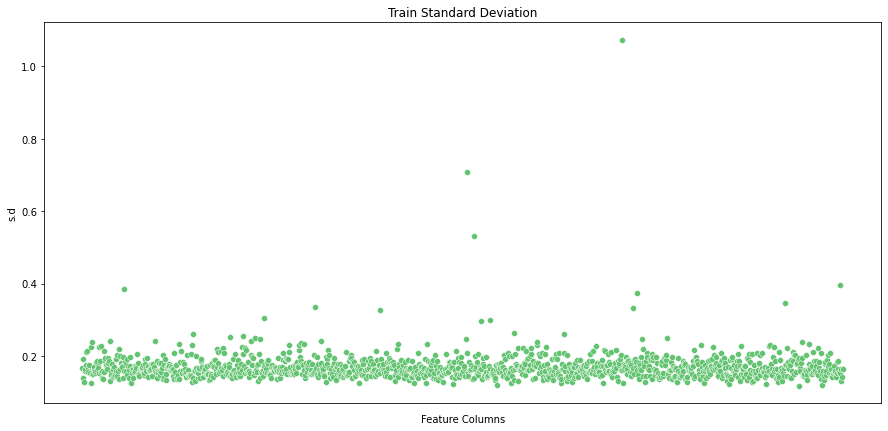

In [17]:
plt.figure(figsize=(15, 7))
sdSns = sns.scatterplot(data=sdVal)
sdSns.set(title='Train Standard Deviation')
sdSns.set(xlabel='Feature Columns')
sdSns.set(ylabel='s.d')
sdSns.set(xticklabels=[])
sdSns.tick_params(bottom=False)

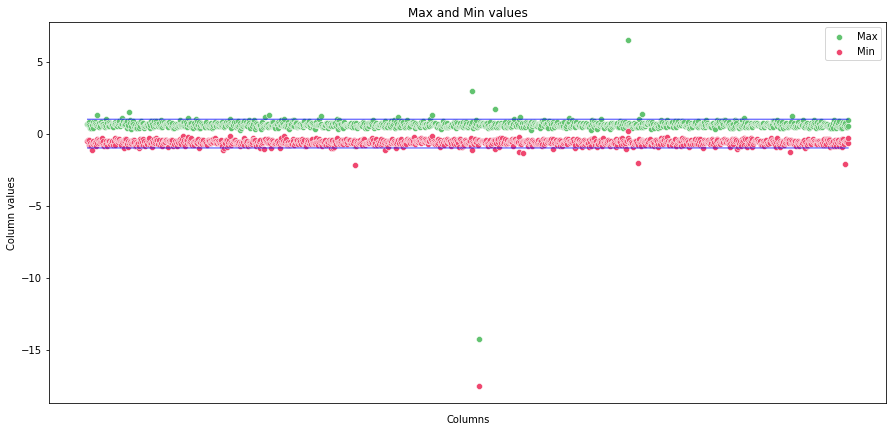

In [18]:
plt.figure(figsize=(15, 7))
plt.title('Max and Min values')
plt.ylabel('Column values')
plt.xlabel('Columns')
maxSns = sns.scatterplot(data=maxVal, label='Max')
maxSns.set(xticklabels=[])
maxSns.tick_params(bottom=False)
sns.scatterplot(data=minVal, label='Min')

sns.lineplot(y=1, x=np.arange(1280), color='blue', linewidth=0.75)
sns.lineplot(y=-1, x=np.arange(1280), color='blue', linewidth=0.75)
plt.legend()

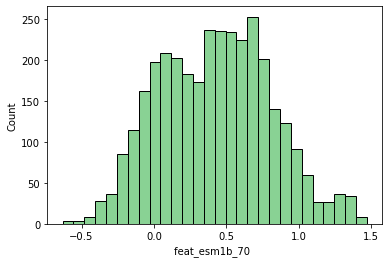

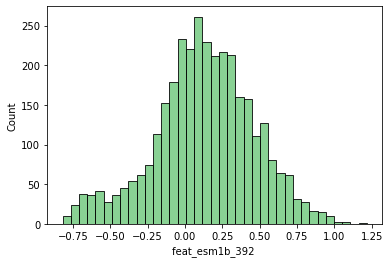

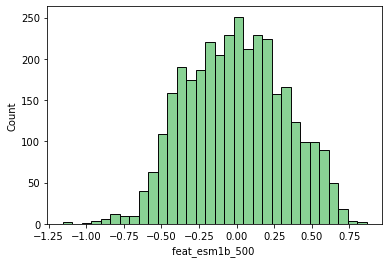

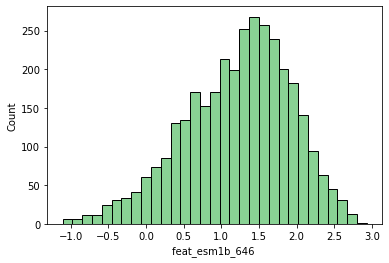

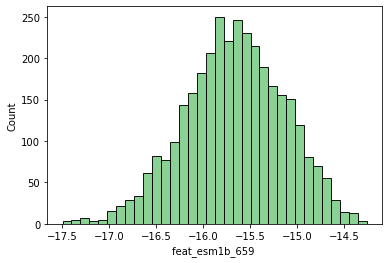

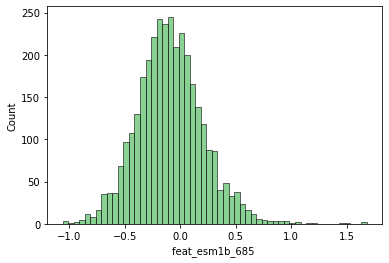

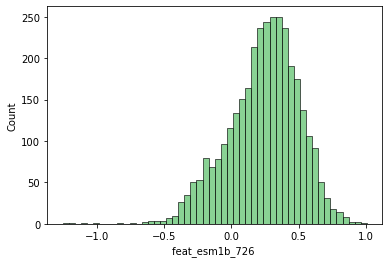

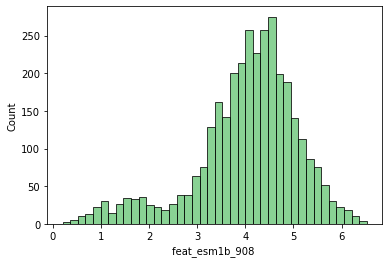

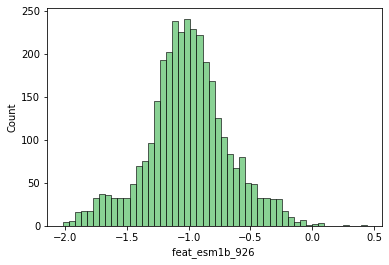

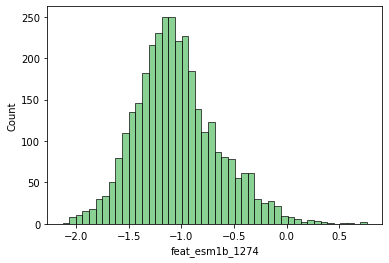

<Figure size 432x288 with 0 Axes>

In [19]:
rangeVal = maxVal - minVal
over = rangeVal[rangeVal > 2] #2.4 train
for x in over.iteritems():
    sns.histplot(data=epiFeat[x[0]])
    plt.figure()

In [20]:
print(over)

feat_esm1b_70      2.101455
feat_esm1b_392     2.036291
feat_esm1b_500     2.025559
feat_esm1b_646     4.040334
feat_esm1b_659     3.235174
feat_esm1b_685     2.744203
feat_esm1b_726     2.266374
feat_esm1b_908     6.328235
feat_esm1b_926     2.462640
feat_esm1b_1274    2.896240
dtype: float64


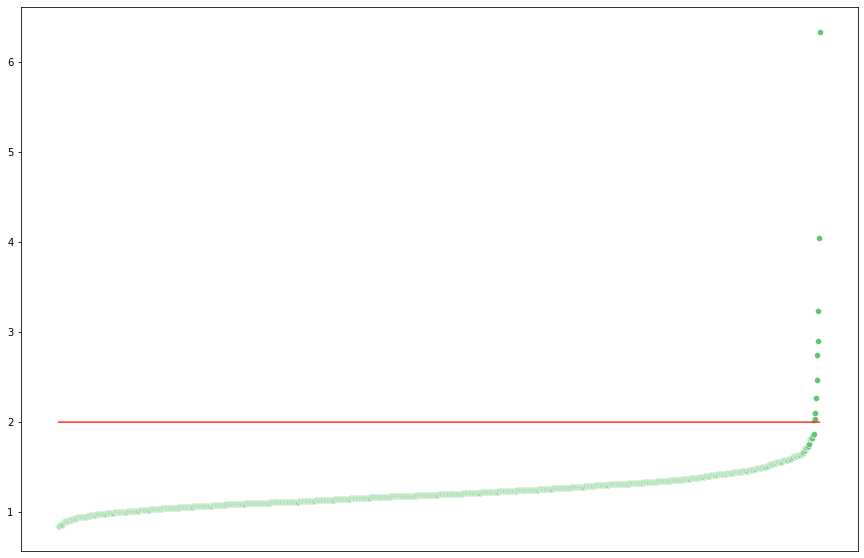

In [21]:
rangeVal.sort_values()
plt.figure(figsize=(15, 10))
r = sns.scatterplot(data=rangeVal.sort_values())
sns.lineplot(x=np.arange(1280), y=2, color='Red', alpha=0.8)
r.set(xticklabels=[])
r.tick_params(bottom=False)

1.319121077656746


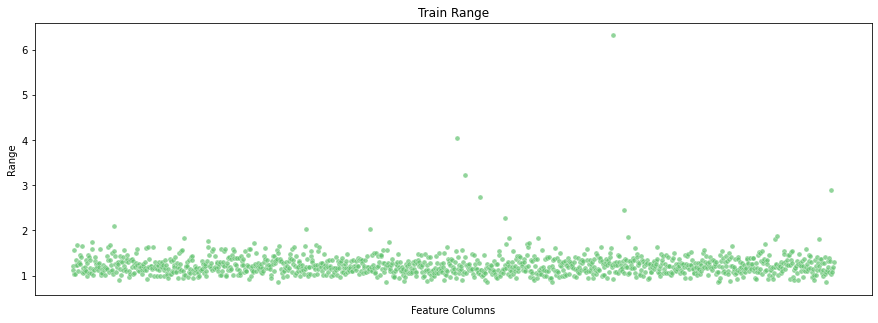

In [22]:
plt.figure(figsize=(15, 5))
# most data stays within reasonable bounds
print(rangeVal.describe()['75%'])

m = sns.scatterplot(data=rangeVal, s=25, alpha=0.7)
#sns.scatterplot(data=minVal, s=5)
#m.scatterplot(data=minVal, s=5)

m.set(title='Train Range')
m.set(xlabel='Feature Columns')
m.set(ylabel='Range')
m.set(xticklabels=[])
m.tick_params(bottom=False)
#sns.scatterplot(data=sdVal)

In [23]:
rangeVal[rangeVal > 3]

feat_esm1b_646     4.040334
feat_esm1b_659     3.235174
feat_esm1b_908     6.328235
dtype: float64

<AxesSubplot:xlabel='feat_esm1b_908 ', ylabel='Count'>

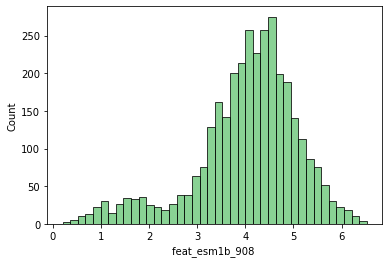

In [24]:
sns.histplot(epiFeat['feat_esm1b_908 '])

<AxesSubplot:xlabel='feat_esm1b_646 ', ylabel='Count'>

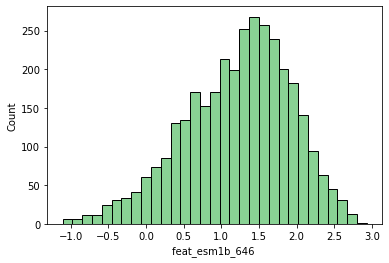

In [25]:
# feat_esm1b_646 - large s.d
sns.histplot(epiFeat['feat_esm1b_646 '])

<AxesSubplot:xlabel='feat_esm1b_1274', ylabel='Count'>

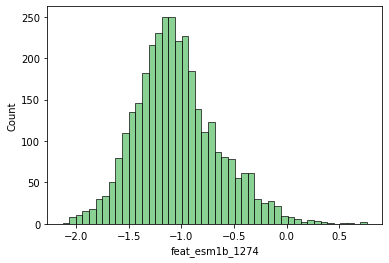

In [26]:
# feat_esm1b_1274 - large s.d
sns.histplot(epiFeat['feat_esm1b_1274'])

<AxesSubplot:xlabel='feat_esm1b_908 ', ylabel='Count'>

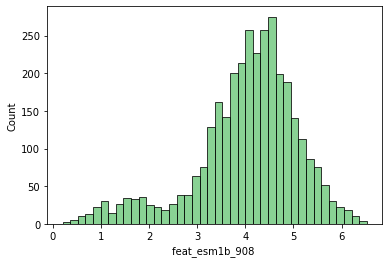

In [27]:
# feat_esm1b_908 - abnormally high max value + large s.d
maxVal[maxVal > 5]
sns.histplot(epiFeat['feat_esm1b_908 '])

<AxesSubplot:xlabel='feat_esm1b_659 ', ylabel='Count'>

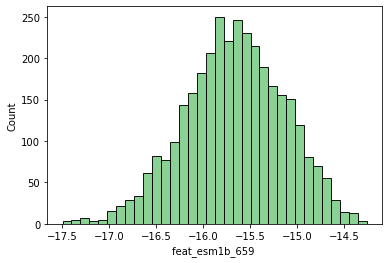

In [28]:
# feat_esm1b_659 - abnormally low max and min value
minVal[minVal<-5] # feat_esm1b_659 
maxVal['feat_esm1b_659 '] # also low
sns.histplot(epiFeat['feat_esm1b_659 '])

## Class Balance

In [29]:
epiPos = epiFeat.loc[epiInfo['Class'] == -1] # only features which are epitope positive
epiNeg = epiFeat.loc[epiInfo['Class'] == 1]

In [ ]:
# Class Distribution
posPcnt = len(epiPos) / (len(epiPos) + len(epiNeg))
print(f'% Positive: {posPcnt}\n% Negative: {1 - posPcnt}')

print(f'Ratio of {posPcnt/(1-posPcnt)}:{(1-posPcnt)/(1-posPcnt)}')

% Positive: 0.6746411483253588
% Negative: 0.3253588516746412
Ratio of 2.0735294117647056:1.0


## Outliers - Skew

Checks for outliers as will affect skewness

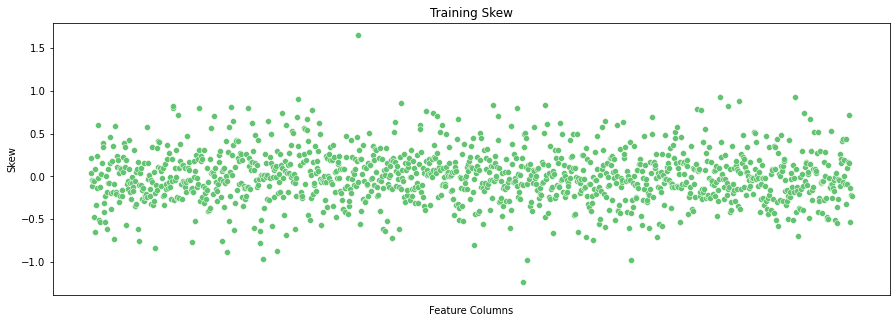

In [ ]:
skew = epiFeat.skew(axis = 0)
plt.figure(figsize=(15, 5))
p = sns.scatterplot(data=skew)
p.set(title='Training Skew')
p.set(xlabel='Feature Columns')
p.set(ylabel='Skew')
p.set(xticklabels=[])
p.tick_params(bottom=False)

<AxesSubplot:xlabel='feat_esm1b_450 ', ylabel='Count'>

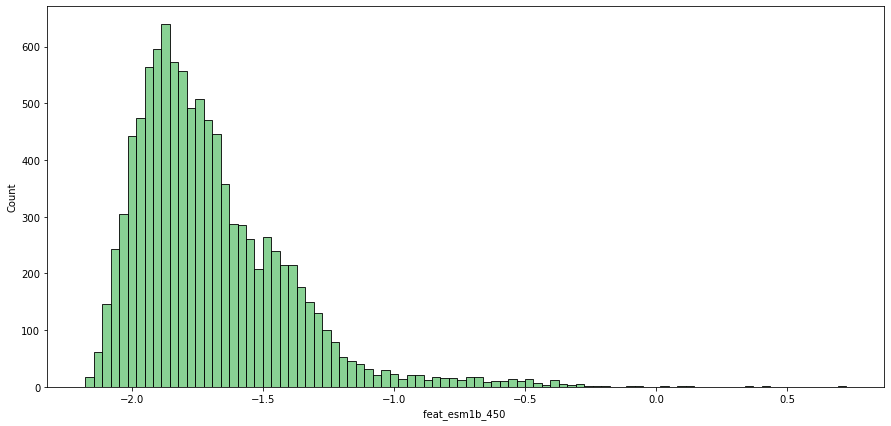

In [ ]:
plt.figure(figsize=(15, 7))

highSkew = skew[abs(skew) > 1.5] # only column is feat_ESM1b_450 (updated - feat_esm1b_450)
#sns.scatterplot(data = epiFeat["feat_esm1b_450 "], s=10)
#plt.figure()
sns.histplot(epiFeat['feat_esm1b_450 '])
#sns.boxplot(epiFeat['feat_esm1b_450 '])
#sns.distplot(epiFeat['feat_esm1b_450 ']);

## Outliers - IQR

In [ ]:
epiFeat25Q = epiFeatDescribed.loc['25%']
epiFeat75Q = epiFeatDescribed.loc['75%']
epiFeatIQR = epiFeat75Q - epiFeat25Q

outlier = pd.DataFrame()
o = []

for col in epiFeat.columns:
    lower = epiFeat25Q[col] - (1.5 * epiFeatIQR[col])
    upper = epiFeat75Q[col] + (1.5 * epiFeatIQR[col])
    e = epiFeat[col]
    mask = ((e > upper)| (e < lower))
    eoutlier = epiFeat[mask]
    
    o.append(eoutlier)


    #outlier.add(eoutlier)
    #print(eoutlier)
    #e = epiFeat[col > upper] | epiFeat[col < lower]

<AxesSubplot:>

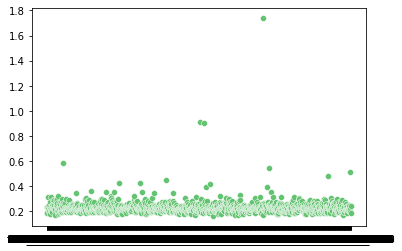

In [ ]:
sns.scatterplot(data=epiFeatIQR)

<AxesSubplot:>

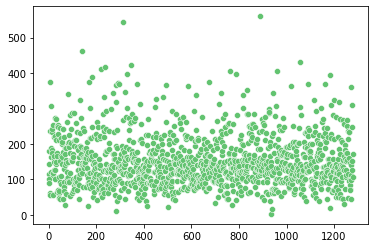

In [ ]:
lenOutlier = [len(x) for x in o]
sns.scatterplot(data=lenOutlier) 

## Variance

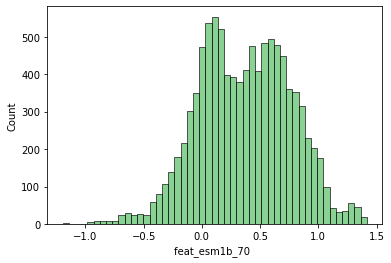

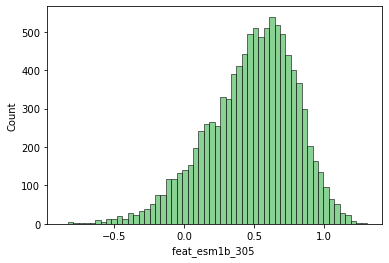

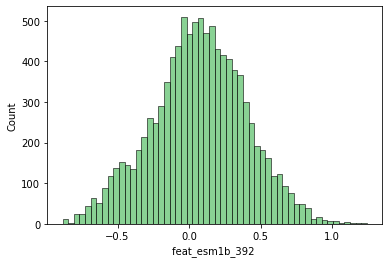

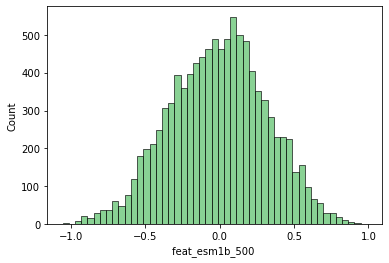

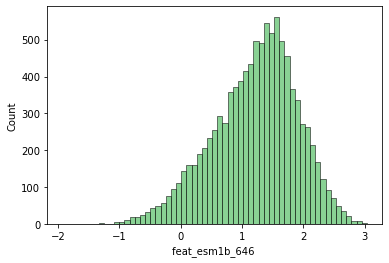

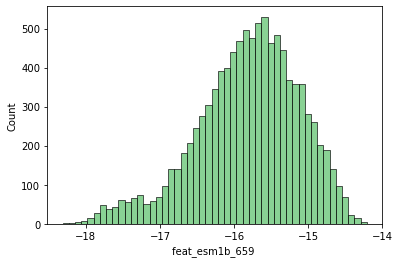

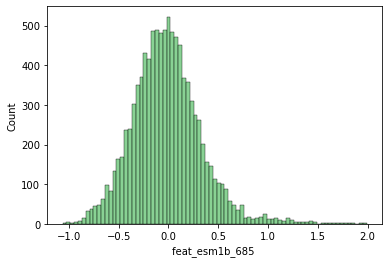

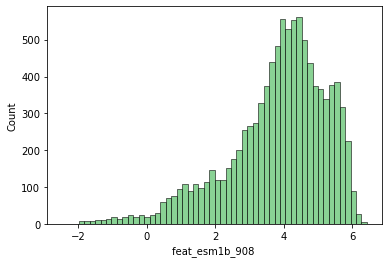

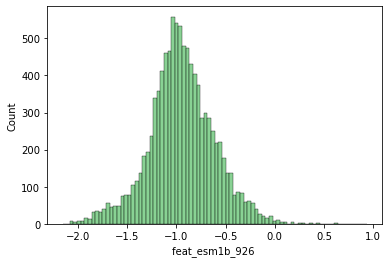

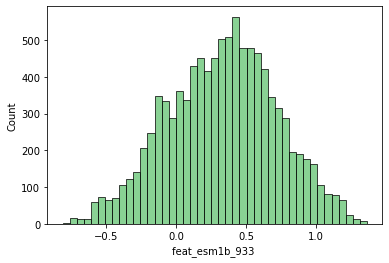

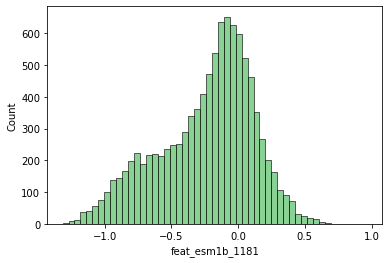

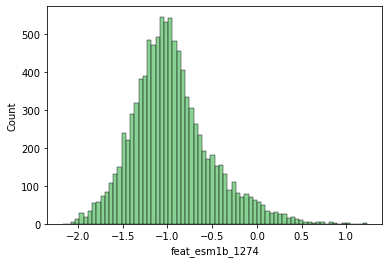

<Figure size 432x288 with 0 Axes>

In [ ]:
epiFeatVar = epiFeat.var()

overVar = epiFeatVar[epiFeatVar > 0.1]

for x in overVar.iteritems():
    sns.histplot(data=epiFeat[x[0]])
    plt.figure()

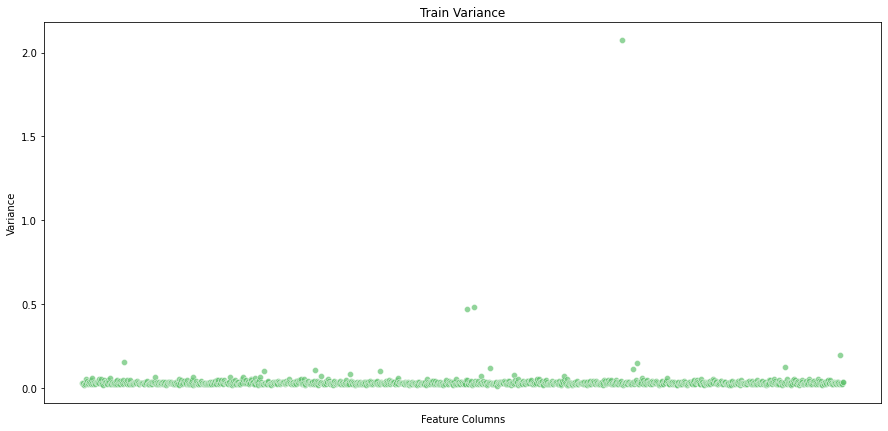

In [ ]:
plt.figure(figsize=(15, 7))
snsVar = sns.scatterplot(data=epiFeatVar, alpha=0.7)
#sns.lineplot(y=0.1, x=np.arange(1270), color='red')
snsVar.set(title='Train Variance')
snsVar.set(xlabel='Feature Columns')
snsVar.set(ylabel='Variance')
snsVar.set(xticklabels=[])
snsVar.tick_params(bottom=False)

<AxesSubplot:>

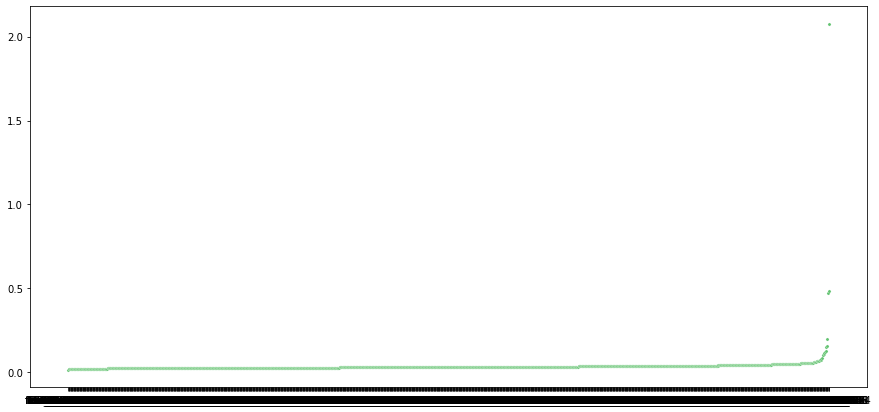

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data = epiFeatVar.sort_values(), s=10)

## Visualisation - t-SNE

In [ ]:
tsne = TSNE(2) # number of components
tSNEepi = pd.DataFrame(epi)
epiPos = tSNEepi.loc[epi['Class'] == 1]
epiNeg = tSNEepi.loc[epi['Class'] == -1]

In [ ]:
tsnePosRes = tsne.fit_transform(epiPos.iloc[:, 15:-1])
tsneNegRes = tsne.fit_transform(epiNeg.iloc[:, 15:-1])

c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


c:\Users\Jorge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'t-SNE Projection of ESM-1b feature embeddings (EBV Virus)'}>

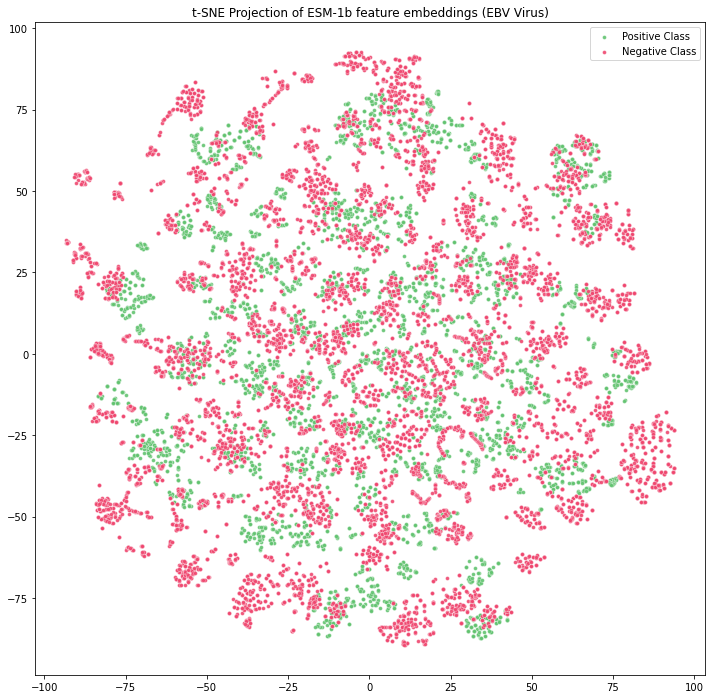

In [ ]:
xPos = [pair[0] for pair in tsnePosRes]
yPos = [pair[1] for pair in tsnePosRes]

xNeg = [pair[0] for pair in tsneNegRes]
yNeg = [pair[1] for pair in tsneNegRes]

plt.figure(figsize=(12, 12))
plt.title(label='t-SNE Projection of ESM-1b feature embeddings (EBV Virus)')
sns.scatterplot(xPos, yPos, s=15, alpha=0.9, label='Positive Class')
sns.scatterplot(xNeg, yNeg, s=15, alpha=0.9, label='Negative Class')

# Pre-Processing

In [ ]:
epiSplitPP = pd.DataFrame(epiSplit)  # full dataset
epiFeatPP = pd.DataFrame(epiSplit.iloc[:, 0:15]) 
epiInfoPP = pd.DataFrame(epiSplit.iloc[:, 15:-1])

## Class Rebalancing: Random Undersampling

In [ ]:
randUS = RandomUnderSampler(random_state=0)
X = epiSplitPP
y = epiSplit['Class']
y.value_counts()

-1    6791
 1    3240
Name: Class, dtype: int64

In [ ]:
Xsample, ysample = randUS.fit_resample(X, y)
#epiPosResample, epiNegResample = randUS.sample(epiPos, epiNeg)
ysample.value_counts()

-1    3240
 1    3240
Name: Class, dtype: int64

In [ ]:
epiSplitPP = pd.DataFrame(Xsample)
epiInfoPP = epiSplitPP.iloc[:, 0:15]
epiSplitPP = epiSplitPP.iloc[:, 15:-1]

## Scaling: Min Max Scaler

In [ ]:
scaler = MinMaxScaler() # between 0 and 1
epiFeatPP = pd.DataFrame(scaler.fit(epiFeat).transform(epiFeat), columns = epiFeat.columns)

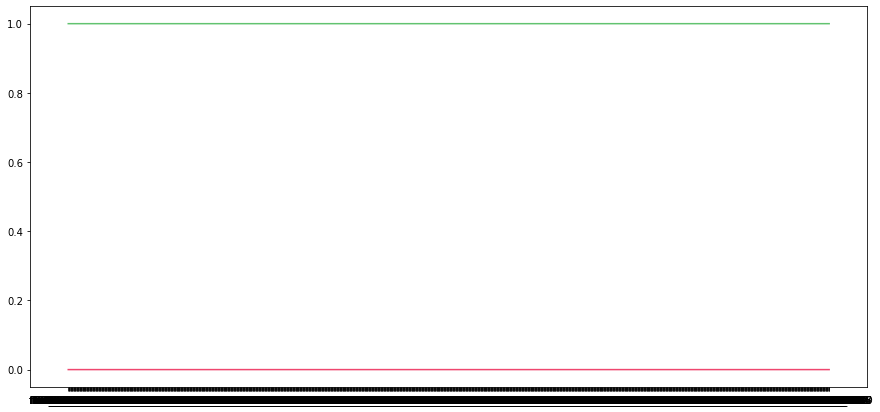

In [ ]:
epiFeatSD = epiFeatPP.describe()
maxVal = epiFeatSD.loc['max']
#epiFeat["feat_esm1b_450 "] # "feat_esm1b_450"
minVal = epiFeatSD.loc['min']

plt.figure(figsize=(15, 7))
plt.plot(maxVal)
plt.plot(minVal)

## [Old] Missing Data - Drop NaN

In [ ]:
#epiFeat = epiFeat.dropna(axis=0) # remove rows (axis=0) containing null data
#epiFeat.dtypes.value_counts()
#epiFeat.isnull().sum().sum()

# Model Fitting and Evaluation

## Data Splits

In [4]:
epiSplit, epiSplit25 = loadAndSplitData() # default to EBV - txid10376

X_train = epiSplit.iloc[:, 15:-1]
y_train = epiSplit['Class']

X_test = epiSplit25.iloc[:, 15:-1]
y_test = epiSplit25['Class']

C:\Users\Jorge\AppData\Local\Temp\ipykernel_9236\3258682893.py:25: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  epi = pd.read_csv(filePath)


## Pipelines + Model Fit/Predict Functions

In [59]:
# custom transformer using MakeTransformer(function here)
# includes class rebalancing, pre-processing (scaling) + classifer
rfPipeline = PipelineImb([
    ('RandomUndersampler', RandomUnderSampler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RFClassifier', RandomForestClassifier())
    ])

svmClf = SVC()
svmClf.probability = True  # tells model to provide % probabilites for each class, instead of binary classifications
svmPipeline = PipelineImb([
    ('RandomUndersampler', RandomUnderSampler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('SVMClassifier', svmClf)
    ])

gbPipeline = PipelineImb([
    ('RandomUndersampler', RandomUnderSampler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('GBClassifier', xgb.XGBClassifier())
    ])


# function to encapsulate both fitting and prediction for models.
# returns predictions as array of tuples where tuple = (p(neg),p(pos))
def rfPred():
    rfPipeline.fit(X_train, y_train)
    return rfPipeline.predict_proba(X_test) 

def svmPred():
    svmPipeline.fit(X_train, y_train)
    return svmPipeline.predict_proba(X_test)

def gbPred():
    # XGB requires class labels as 0 and 1 (not -1 and 1 as current)
    y_trainXGB = []
    for i in y_train:
        if i == -1:
            y_trainXGB.append(0)
        else:
            y_trainXGB.append(i)
    y_trainXGB = pd.Series(y_trainXGB)

    gbPipeline.fit(X_train, y_trainXGB)
    return gbPipeline.predict_proba(X_test)

# dict of functions to access of different models
modelDict = {
    'rf': rfPred,
    'svm': svmPred,
    'gb': gbPred
    }


# single model
def modelPred(model): 
    return modelDict[model]

# all models
def modelpredAll():
    preds = []
    for model, f in modelDict:
        preds.append(model, f())

    return preds

# threshold predition % after model prediction. reduces both model class preds and real class data
def thresholdResult(y_pred, t=0.5):
    y_predBin = []
    for p in y_pred:
        if p > t:
            y_predBin.append(1)
        else:
            y_predBin.append(-1)
    return y_predBin

def getAUCScore(y_test, y_pred):
    return metrics.roc_auc_score(y_test, y_pred)

def getMCCScore(y_test, y_pred):
    return metrics.matthews_corrcoef(y_test, y_pred)

def getScores(y_test, y_pred):
    return {'AUC': getAUCScore(y_test, y_pred), 'MCC': getMCCScore(y_test, thresholdResult(y_pred)),
            'SENS': metrics.recall_score(y_test, thresholdResult(y_pred)),
            'Precision': metrics.precision_score(y_test, thresholdResult(y_pred))}

def thresholdAndGetAUCScore(y_test, y_pred):
    return getAUCScore(*thresholdResult(y_test, y_pred))

def saveModel(fileName, model):
    with open(fileName + '.pkl','wb') as f:
        pickle.dump(model,f)

def loadModel(fileName):
    with open(fileName + '.pkl', 'rb') as f:
        return pickle.load(f)


## Model Fitting + Prediction

In [21]:
y_predSVM = modelPred('svm')()[:, 1]  # returns list of tuples (-1%, 1%). index 1 of tuple is pos %, so get this only
y_predRF = modelPred('rf')()[:, 1]
y_predGB = modelPred('gb')()[:, 1]

<AxesSubplot:>

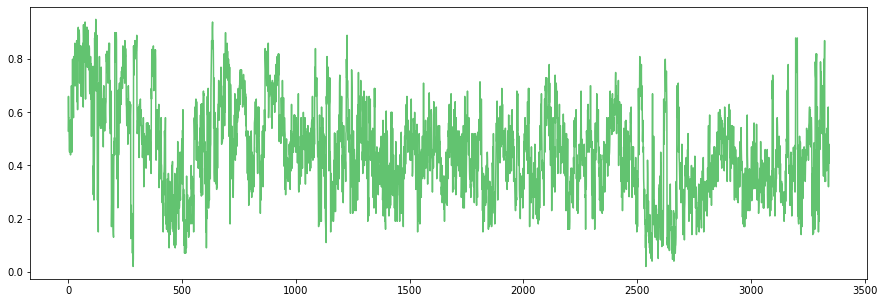

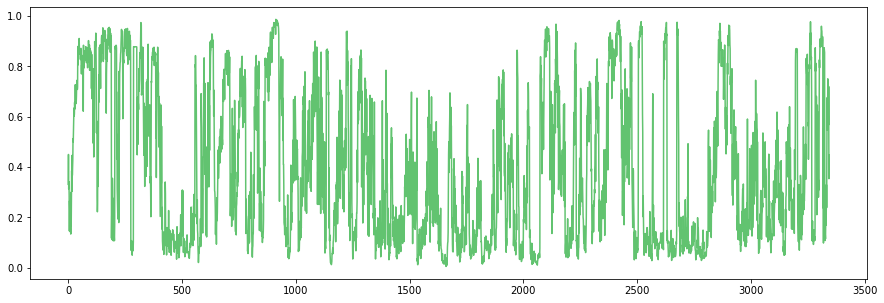

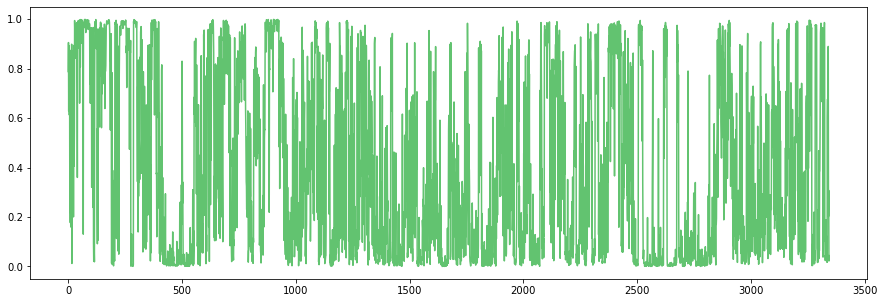

In [29]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_predRF)
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_predSVM)
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_predGB)

## Model Evaluation

In [64]:
aucSVM = getScores(y_test, y_predSVM) #thresholdAndGetAUCScore(y_test, y_predSVM)
aucRF = getScores(y_test, y_predRF) #thresholdAndGetAUCScore(y_test, y_predRF)
aucGB = getScores(y_test, y_predGB) #thresholdAndGetAUCScore(y_test, y_predGB)
print(f'SVM AUC Score: {aucSVM}\nRF AUC Score: {aucRF}\nGB AUC Score: {aucGB}')

SVM AUC Score: {'AUC': 0.7337215138715061, 'MCC': 0.3373900195341547, 'SENS': 0.5753676470588235, 'Precision': 0.5434027777777778}
RF AUC Score: {'AUC': 0.7104624595848977, 'MCC': 0.29874486972086006, 'SENS': 0.546875, 'Precision': 0.5191972076788831}
GB AUC Score: {'AUC': 0.7082241473717146, 'MCC': 0.28441348031068026, 'SENS': 0.5726102941176471, 'Precision': 0.4976038338658147}


In [61]:
t = thresholdResult(y_predSVM)

In [63]:
getScores(y_test, y_predSVM)


{'AUC': 0.7337215138715061,
 'MCC': 0.3373900195341547,
 'SENS': 0.5753676470588235,
 'Precision': 0.5434027777777778}

In [27]:
pred = thresholdResult(y_pred=y_predSVM)

c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_cla

'              precision    recall  f1-score   support\n\n          -1       0.00      0.00      0.00         0\n           0       0.00      0.00      0.00      2192\n           1       0.58      0.54      0.56      1152\n\n    accuracy                           0.19      3344\n   macro avg       0.19      0.18      0.19      3344\nweighted avg       0.20      0.19      0.19      3344\n'

In [35]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      2256
           0       0.00      0.00      0.00         0
           1       0.54      0.58      0.56      1088

    accuracy                           0.19      3344
   macro avg       0.18      0.19      0.19      3344
weighted avg       0.18      0.19      0.18      3344



c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\metrics\_cla